## Описание проекта, загрузка и подготовка данных

### Введение
______
**Название проекта**  

Разработка алгоритма принятия решения для определения региона бурения новых скважин добывающей компании «ГлавРосГосНефть».
_____

**Цель исследования**  

Построения моделей для предсказания объёма запасов в новых скважинах и определение региона с максимальной суммарной прибылью отобранных скважин.
_______
**Задачи исследования**

- Провести необходимую предобработку датасетов с данными о пробах нефти в трёх регионах
- Провести исследовательский анализ данных с учетом их типа
- Провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования
- Построить модели для предсказания объёма запасов в новых скважинах для каждого регина
- Отобрать скважины с самыми высокими оценками значений запасов
- Рассчитать достаточный объём сырья для безубыточной разработки новой скважины
- Рассчитать риски и прибыль для каждого региона с применением техники Bootstrap
- Определить регион с максимальной суммарной прибылью отобранных скважин и вероятностью убытков меньше заданного значения
_____
**Исходные данные**  

Имеются данные, представленные в виде трех датасетов, разбитые по исследуемым регионам, которые содержат следующую информацию:

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — значимые признаки точек;
- `product` — объём запасов в скважине (тыс. баррелей)

### Установка и импорт библиотек

In [8]:
!pip install -U scikit-learn -q
!pip install phik -q

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import os
import phik
import math
import warnings
import re

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy.stats import uniform
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    r2_score,
    make_scorer
)

In [11]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [12]:
# объявление констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Объявление функций

In [14]:
# функция для краткого обзора датасетов
def view_df(df):
    display(df.head()) 
    display(df.info()) 
    display(df.columns) 

In [15]:
# функция для описания непрерывных признаков при статистическом анализе
def histbox_plot(df, list_col):
    for name in list_col:
        i = 1
        plt.figure(figsize=(12, 4))
        plt.suptitle(f'Гистограмма и диаграмма размаха признака - {name}', 
                     fontsize = 13, fontweight='bold')
    
        plt.subplot(i, 2, i) 
        sns.histplot(data=df, x=name, kde=True)
    
        plt.subplot(i, 2, i+1)
        sns.boxplot(data=df, x=name)
    
        plt.tight_layout()
        plt.show();
    
        display(df[name].describe())

In [16]:
# функция для построения матрицы Phik
def phik_matrix_(df, interval_cols, region):
    
    phik_overview = phik_matrix(df, interval_cols=interval_cols) 
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=f'матрица $\phi_K$ - регион {region}',
        fontsize_factor=1,
        figsize=(7, 4)
    )

In [17]:
# функция для расчета модели, метрик, прогноза запасов
def model(df, region):
    # разобъем данные на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['product'], axis=1),
        df['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)

    # создаём списки с названиями признаков
    num_columns = num_col_geo[:-1]

    # создаём общий пайплайн для подготовки данных
    data_preprocessor = ColumnTransformer(
        [
         ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    # создаём итоговый пайплайн: подготовка данных и модель
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', None)
    ])

    param_grid = [
        # словарь для модели LinearRegression()
        {
            'models': [LinearRegression()],
            'models__fit_intercept': [True, False],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
        },

        # словарь для модели Ridge()
        {
            'models': [Ridge(random_state=RANDOM_STATE)],
            'models__alpha': uniform(0.1, 10),
            'models__tol': [0.0001, 0.001, 0.01],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
        },

        # словарь для модели Lasso()
        {
            'models': [Lasso(random_state=RANDOM_STATE)],
            'models__alpha': uniform(0.1, 10),
            'models__tol': [0.0001, 0.001, 0.01],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
        }
    ]

    randomized_search = RandomizedSearchCV(
        pipe_final, 
        param_grid, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_iter=30
    )
    randomized_search.fit(X_train, y_train)

    display('Лучшая модель и её параметры:', randomized_search.best_params_)
    print ('Метрика RMSE, полученная с помощью кросс-валидации:', randomized_search.best_score_ * -1)

    # рассчитаем прогноз и метрики R2, RMSE на валидационных данных
    y_pred = randomized_search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('\n'
          f'Метрика R2 на валидационных данных: {r2:.3f}'
          '\n'f'Метрика RMSE на валидационных данных: {rmse:.3f}'
         '\n'f'Прогноз среднего запаса сырья в регионе {region}: {np.mean(y_pred):.3f}')
    
    return y_test, y_pred, r2, rmse

In [29]:
# функция для для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit_region(reserv_, reserv_pred_):
    reserv_pred_sorted = reserv_pred_.sort_values(ascending=False).head(WELLS_LIMIT)
    reserv_selected = reserv_[reserv_pred_sorted.index]
    
    profit_region = reserv_selected.sum() * INCOME_TBAR - BUDGET_REGION
    return profit_region

### Загрузка данных

In [31]:
pth1 = r'C:\Ipynb\datasets\geo_data_0.csv'
pth2 = r'C:\Ipynb\datasets\geo_data_1.csv'
pth3 = r'C:\Ipynb\datasets\geo_data_2.csv'

if os.path.exists(pth1) & os.path.exists(pth2) & os.path.exists(pth3):
    geo_0 = pd.read_csv(pth1, sep=',')
    geo_1 = pd.read_csv(pth2, sep=',')
    geo_2 = pd.read_csv(pth3, sep=',')
else:
    print('Something is wrong with loading data')

### Общая информация о датасетах

In [33]:
list_df = [geo_0, geo_1, geo_2]

for df in list_df:
    view_df(df)
    print('==================================================================')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

**Вывод:** загружена и получена общая информация по датасетам. В данных отсутствуют пропуски. Названия столбцов соответствуют "змеиному типу". Данные и их тип соответствуют описанию. Более подробный анализ, а также выявление дубликатов, аномальных значений и пр. будут произведены на следующих этапах обработки данных.

##  Предобработка данных

### Обработка дубликатов

#### Обработка неявных дубликатов

In [39]:
print('Уникальные значения в столбцах:\n')
for df in list_df:
    for column in df.select_dtypes(exclude=[np.number]).columns.values:
        print(f'"{column}": {df[column].nunique()}')
    print()

Уникальные значения в столбцах:

"id": 99990

"id": 99996

"id": 99996



In [40]:
for df in list_df:
    print(df[df.duplicated(subset = 'id',  keep=False)].sort_values(by='id'),'\n')

          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

Видим, что в датасетах присутствуют одинаковые скважины, при этом значения признаков по ним сильно различаются. Для принятия решения об исключении конкретных строк с одинаковым id требуется мнение эксперта, из-за его отсутствия, оставим в датасетах данные записи

#### Обработка явных дубликатов

In [43]:
for df in list_df:
    print(df.duplicated().sum())

0
0
0


**Вывод:** по результатам предобработки данных было принято решение о сохранении записей в датасетах с одинаковыми id, явные дубликаты отсутствуют.

## Исследовательский анализ данных






### Проведение статистического анализа признаков датасета `geo_0`

Выделим признаки для анализа

In [48]:
num_col_geo = geo_0.iloc[:, 1:].select_dtypes(include='number').columns.tolist()
num_col_geo

['f0', 'f1', 'f2', 'product']

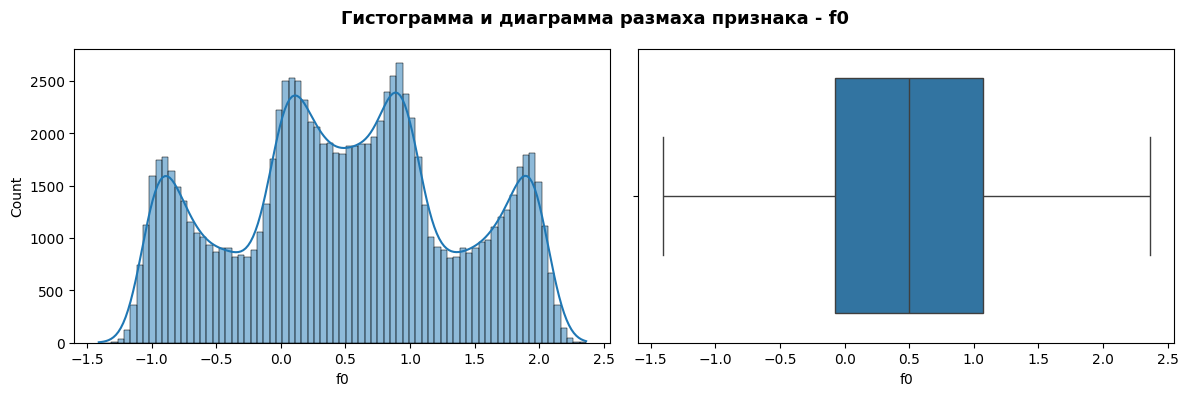

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64

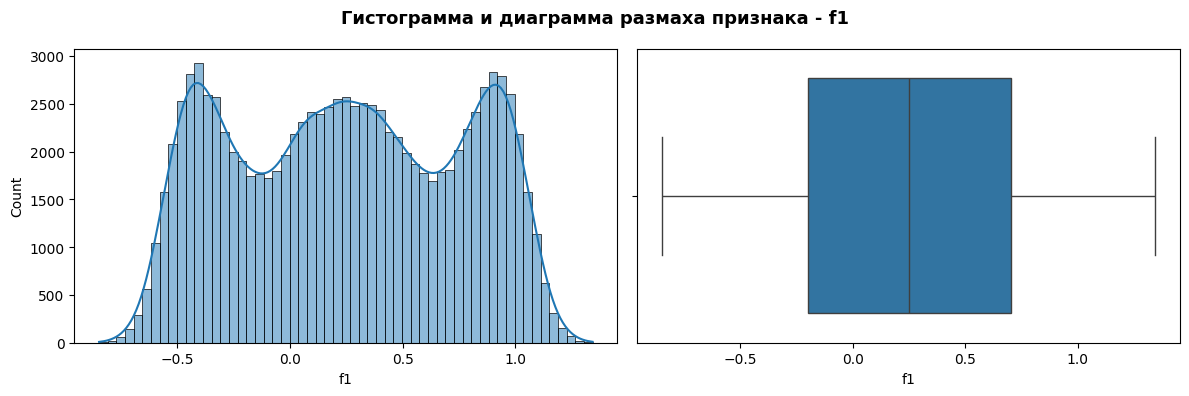

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64

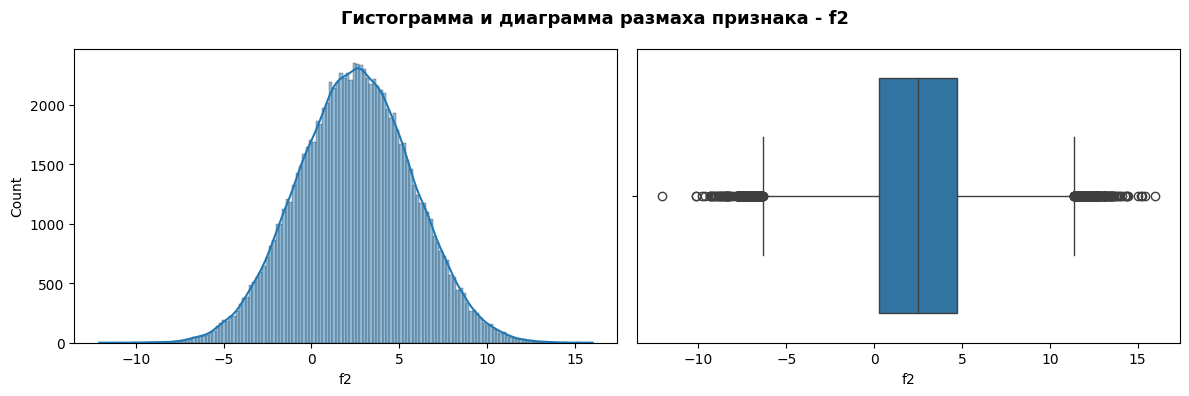

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64

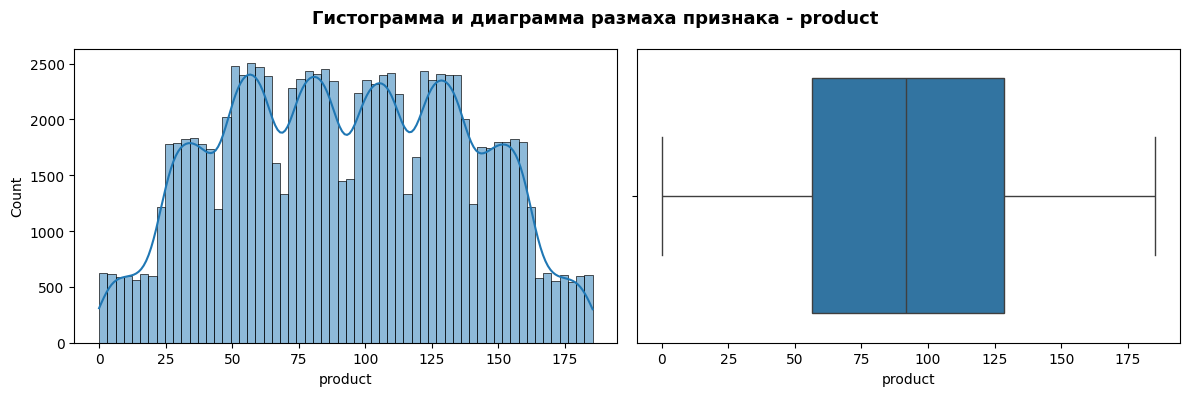

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [49]:
histbox_plot(geo_0, num_col_geo)

Из диаграмм и таблиц видно, что аномальных выбросов в количественных признаках не наблюдается.  Близкое к нормальному распределению имеет только признак `f2`,остальные признаки имеют явно ненормальное распределение: смещение вершин к границам диапазона, несколько вершин и т.д., учтем это в дальнейшем при выборе критерия корреляции.

### Проведение статистического анализа признаков датасета `geo_1`

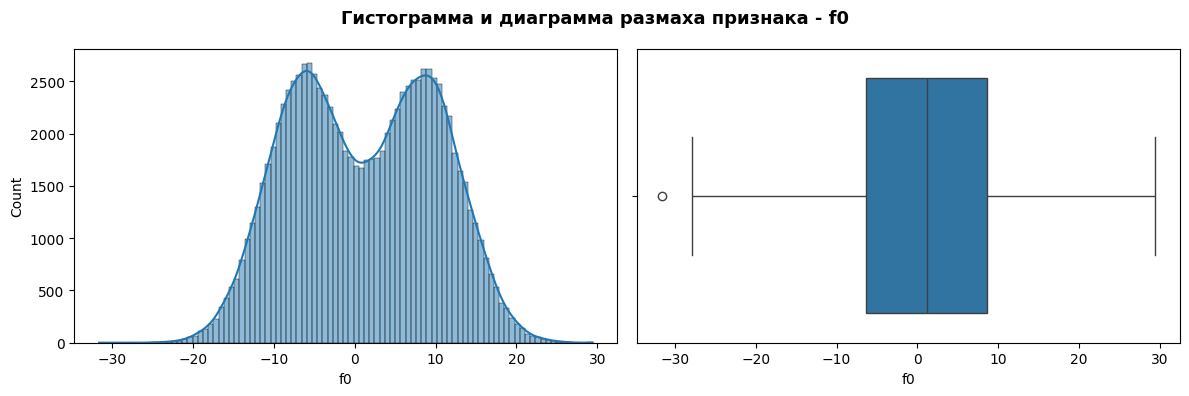

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64

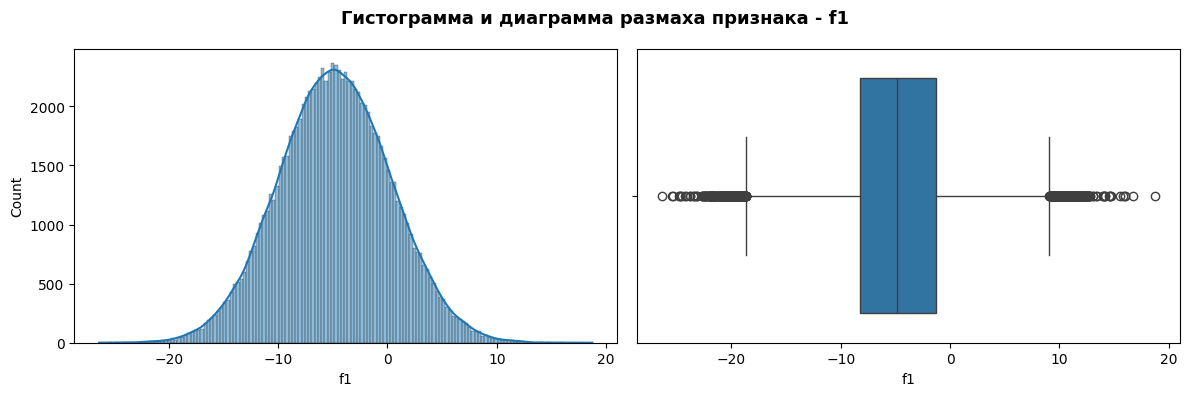

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64

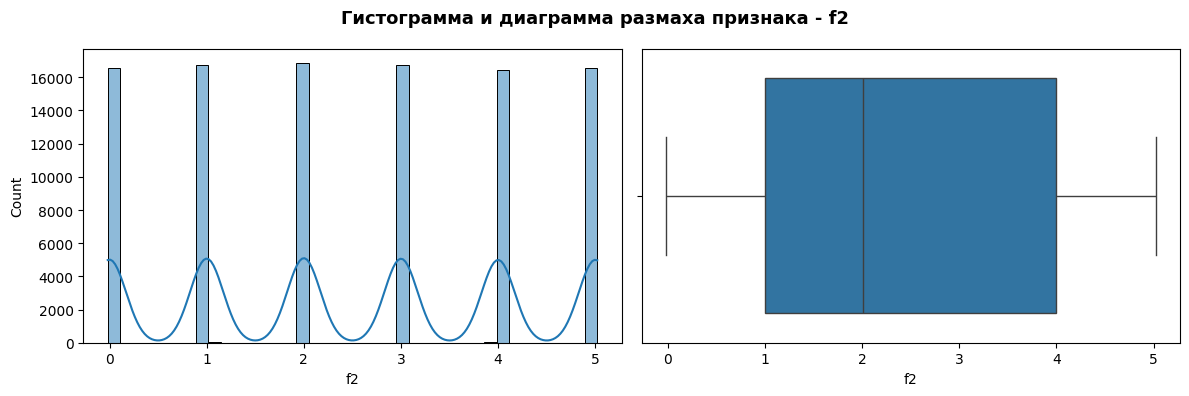

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64

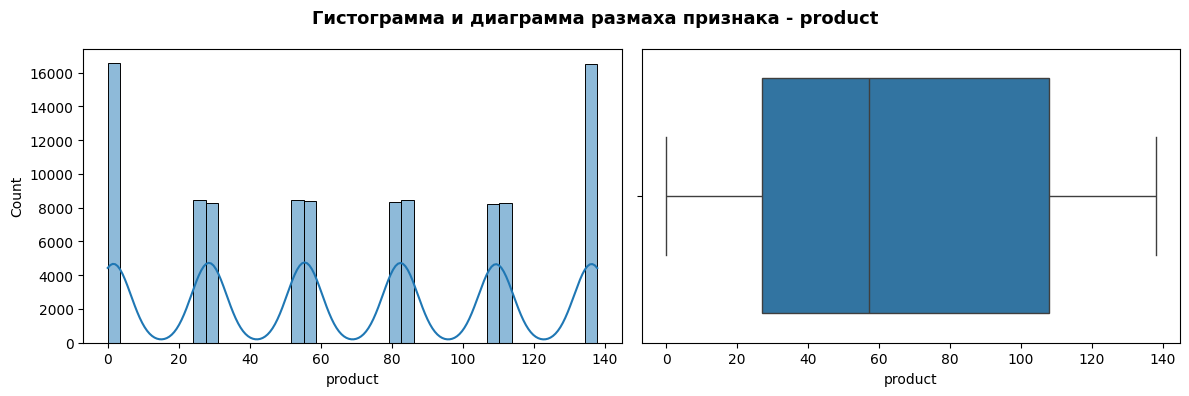

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [52]:
histbox_plot(geo_1, num_col_geo)

Из диаграмм и таблиц видно, что аномальных выбросов в количественных признаках не наблюдается.  Близкое к нормальному распределению имеет только признак `f1`,остальные признаки имеют явно ненормальное распределение: несколько вершин, пропуски и т.д., учтем это в дальнейшем при выборе критерия корреляции. Признаки `f2` и `product` хоть и являются непрерывными, при этом заметно группируются возле определенных значений.

### Проведение статистического анализа признаков датасета `geo_2`

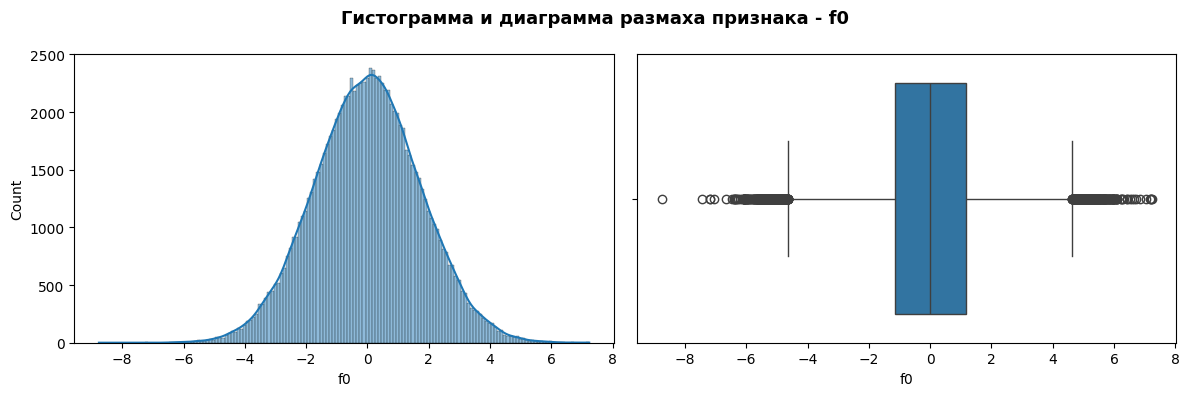

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64

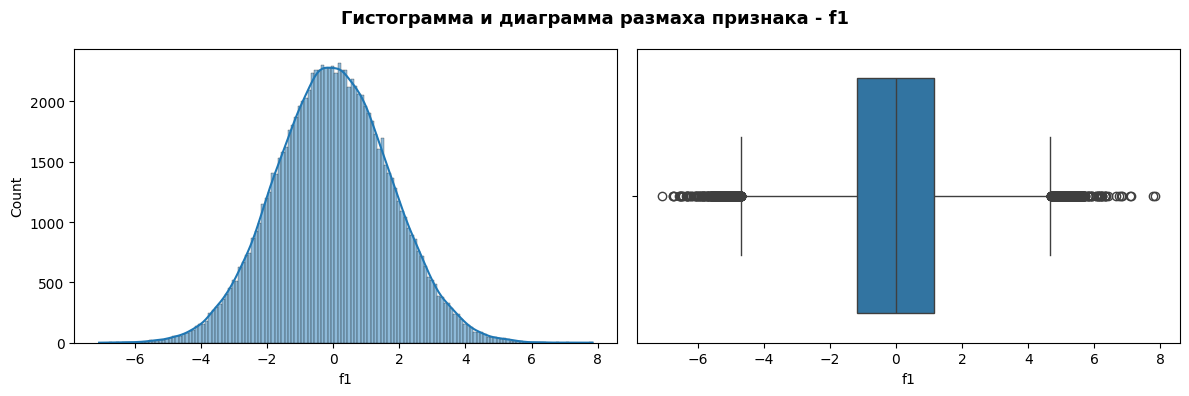

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64

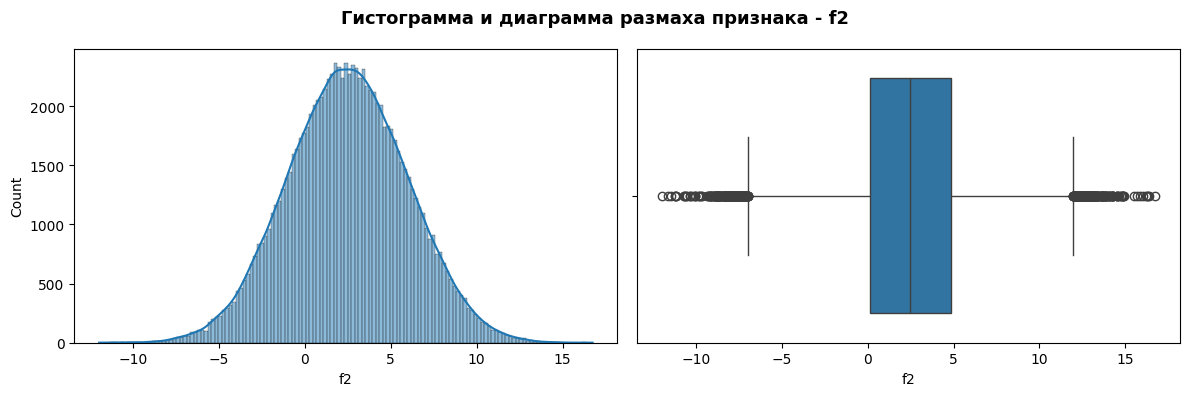

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64

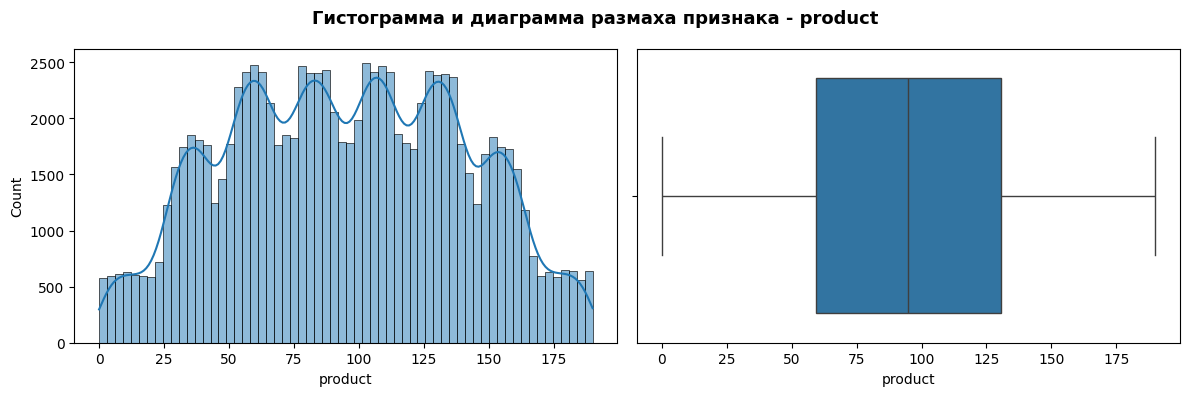

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [57]:
histbox_plot(geo_2, num_col_geo)

Из диаграмм и таблиц видно, что аномальных выбросов в количественных признаках не наблюдается.  Близкое к нормальному распределению имеют все признаки, кроме `product`, учтем это в дальнейшем при выборе критерия корреляции.

## Корреляционный анализ

Установим столбец `id` в качестве индексного

In [61]:
df_names = ['geo_0', 'geo_1', 'geo_2']
for name in df_names:
    globals()[name].set_index('id', inplace=True)

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем $\phi_k$ матрицу, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

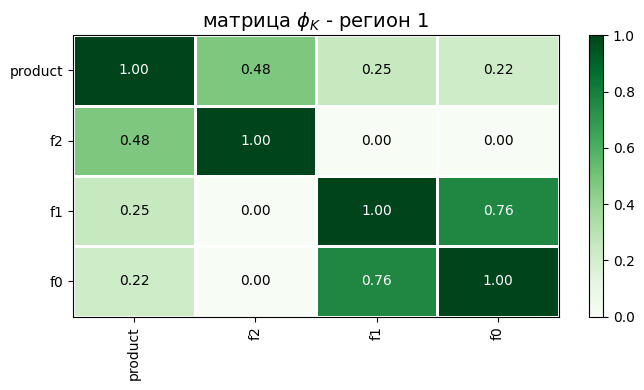

In [63]:
phik_matrix_(geo_0, num_col_geo, 1)

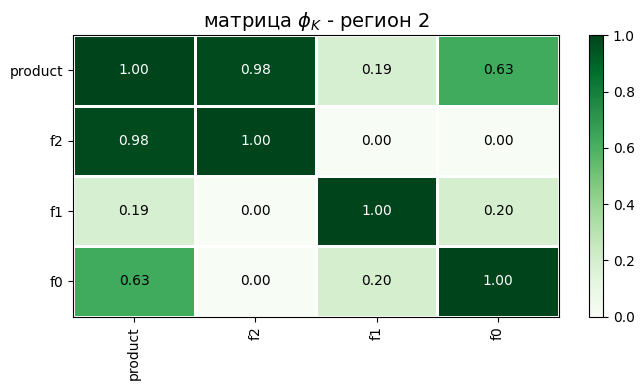

In [64]:
phik_matrix_(geo_1, num_col_geo, 2)

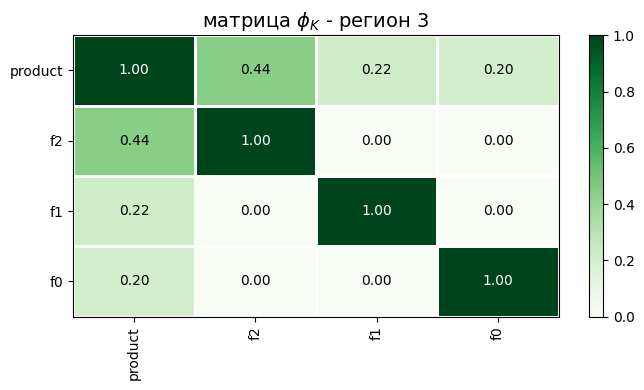

In [65]:
phik_matrix_(geo_2, num_col_geo, 3)

**Вывод:** из анализа матриц для регионов видно, что:
 - в первом регионе
   - между целевым признаком и остальными корреляция умеренная и ниже
   - между признаками `f1` и `f0` наблюдается высокая корреляция
 
- во втором регионе
   - между целевым признаком и `f2` наблюдается очень высокая корреляция, с признаком `f0` - средняя корреляция
   - между входными признаками корреляция очень слабая или отсутствует
   
- во третьем регионе
   - между целевым признаком и остальными корреляция умеренная и ниже
   - между входными признаками корреляция очень слабая или отсутствует

## Обучение и проверка модели

Проверим наличие неявных дубликатов без учета признака `id`, т.е среди тех признаков, которые будут использоваться для обучения модели 

In [70]:
for df in list_df:
    print(df.duplicated().sum())

0
0
0


### Настройки подбора модели

Для подбора модели будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров `RandomizedSearchCV`. Выбор лучшей модели будет осуществляться на основе метрики, предложенной в проекте — `RMSE`

В рамках пайплайна используются следующие инструменты:    

для масштабирования количественных признаков:
- `StandardScaler, MinMaxScaler, RobustScaler`, без масштабирования

типы методов:
- `LinearRegression, Ridge, Lasso` со своими настройками гиперпараметров

#### Модель и прогноз запасов для первого региона

In [74]:
reserv_1, reserv_1_pred, r2_1, rmse_1 = model(geo_0, 1)

'Лучшая модель и её параметры:'

{'models': Ridge(random_state=42),
 'models__alpha': 9.36658865793794,
 'models__tol': 0.01,
 'preprocessor__num': 'passthrough'}

Метрика RMSE, полученная с помощью кросс-валидации: 37.67200501183212

Метрика R2 на валидационных данных: 0.273
Метрика RMSE на валидационных данных: 37.757
Прогноз среднего запаса сырья в регионе 1: 92.399


#### Модель и прогноз запасов для второго региона

In [76]:
reserv_2, reserv_2_pred, r2_2, rmse_2 = model(geo_1, 2)

'Лучшая модель и её параметры:'

{'models': LinearRegression(),
 'models__fit_intercept': True,
 'preprocessor__num': RobustScaler()}

Метрика RMSE, полученная с помощью кросс-валидации: 0.8904559629285671

Метрика R2 на валидационных данных: 1.000
Метрика RMSE на валидационных данных: 0.890
Прогноз среднего запаса сырья в регионе 2: 68.713


#### Модель и прогноз запасов для третьего региона

In [78]:
reserv_3, reserv_3_pred, r2_3, rmse_3 = model(geo_2, 3)

'Лучшая модель и её параметры:'

{'models': Lasso(random_state=42),
 'models__alpha': 0.30584494295802445,
 'models__tol': 0.001,
 'preprocessor__num': 'passthrough'}

Метрика RMSE, полученная с помощью кросс-валидации: 40.026320837907875

Метрика R2 на валидационных данных: 0.196
Метрика RMSE на валидационных данных: 40.145
Прогноз среднего запаса сырья в регионе 3: 94.772


Отобразим результаты в сводной таблице

In [82]:
regions = ['region_1', 'region_2', 'region_3']
data = [
    [r2_1, r2_2, r2_3],
    [rmse_1, rmse_2, rmse_3],
    [reserv_1_pred.mean(), reserv_2_pred.mean(), reserv_3_pred.mean()]
]
data = pd.DataFrame(data=data, columns=regions)
data = data.T
data.columns = ['r2', 'rmse', 'reserves']
round(data, 3)

,r2,rmse,reserves
region_1,0.273,37.757,92.399
region_2,1.000,0.890,68.713
region_3,0.196,40.145,94.772


**Вывод:** анализ метрик моделей и прогнозов запасов сырья показывают:
- коэффициент R2, оценивающий обобщающую способность модели, выше всего для модели региона 2, что объясняется высокой корелляцией признаков с целевым для этого региона. R2 для регионов 1 и 3 крайне низкие, всего в 27% и 20% процентах случаев соответственно предсказание модели ближе к истине, чем среднее значение целевого признака
- по той же причине самое низкое значение среднеквадратичной ошибки в регионе 2, в регионах 1 и 3 ошибка составляет `37.8` и `40.1` соответственно
- примерно схожие средние запасы сырья прогнозируются в регионе 1 и 3 - `92.4-94.8`, прогноз по региону 2 имеет более низкое значение - `68.7`

## Подготовка к расчёту прибыли

### Расчет объёма сырья для безубыточной разработки новой скважины

По условию задачи выбираются 200 лучших скважин для разработки при бюджете на разработку скважин в регионе — 10 млрд рублей. Доход с каждой единицы продукта составляет 450 тыс. рублей.

In [88]:
# бюджет на разработку одной скважины
BUDGET_REGION = 10_000_000_000
WELLS_LIMIT = 200
well_budget = BUDGET_REGION / WELLS_LIMIT

INCOME_TBAR = 450_000
reserv_no_loss = well_budget/INCOME_TBAR
print(f'Объем сырья для безубыточной разработки новой скважины: {reserv_no_loss:.2f} тыс.барр.')

Объем сырья для безубыточной разработки новой скважины: 111.11 тыс.барр.


Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [91]:
n = 0
for i in regions:
    if data.loc[i, 'reserves'] > reserv_no_loss:
        n +=1
print('Количество регионов со средним запасом, превышающий безубыточный:', n)

Количество регионов со средним запасом, превышающий безубыточный: 0


Отобразим на гистограммах распределение прогнозов запасов по регионам с указанием рассчитанной величины запаса для безубыточной разработки новой скважины

In [93]:
reserv_1_pred = pd.Series(reserv_1_pred, name='region_1')
reserv_2_pred = pd.Series(reserv_2_pred, name='region_2')
reserv_3_pred = pd.Series(reserv_3_pred, name='region_3')

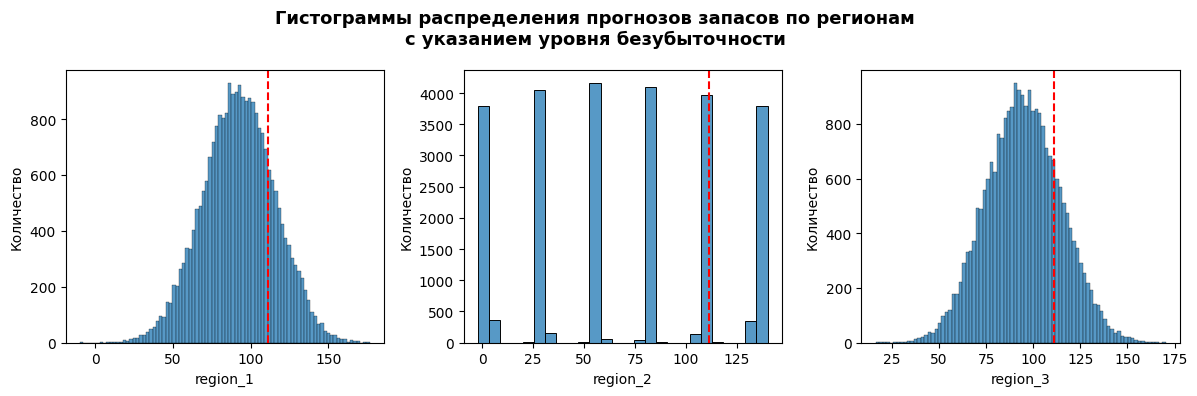

In [94]:
reserv_pred = [reserv_1_pred, reserv_2_pred, reserv_3_pred]

i = 1
plt.figure(figsize=(12, 4))
plt.suptitle(f'Гистограммы распределения прогнозов запасов по регионам'
             '\n'f'с указанием уровня безубыточности', fontsize = 13, fontweight='bold')
for df in reserv_pred:
    plt.subplot(1, 3, i)
    sns.histplot(data=df)
    plt.axvline(reserv_no_loss, color='red', linestyle='--')
    plt.ylabel('Количество')
    i +=1

plt.tight_layout()
plt.show();

**Вывод:** исходя из объема сырья необходимого для безубыточной разработки новой скважины в 111.11 барр, ни в одном из регионов средний запас не достиг безубыточного уровня, при этом в каждом регионе имеются скважины с прогнозом запаса превышающего запас для безубыточности, т.е. в каждом регионе необходимо провести работу по отбору необходимых скважин.

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Сбросим индексы в истинных значениях запасов для приведения их к идентичным с прогнозными значениями

In [99]:
reserv_1 = reserv_1.reset_index(drop=True)
reserv_2 = reserv_2.reset_index(drop=True)
reserv_3 = reserv_3.reset_index(drop=True)
reserv = [reserv_1, reserv_2, reserv_3]

Рассчитаем прибыль по регионам, исходя из устройства 200 лучших по прогнозам из всех скважин в каждом из них

In [101]:
for i in range(len(reserv)):
    profit = profit_region(reserv[i], reserv_pred[i])
    print(f'Прибыль в регионе {i+1} составляет: {profit:_.0f} руб.')

Прибыль в регионе 1 составляет: 3_359_141_114 руб.
Прибыль в регионе 2 составляет: 2_415_086_697 руб.
Прибыль в регионе 3 составляет: 2_602_895_151 руб.


## Расчёт прибыли и рисков 

По условию задачи при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Для каждого региона рассчитаем среднюю прибыль, 95%-й доверительный интервал для нее и вероятность убытков.

In [104]:
frac = 500 / len(reserv_1)
state = np.random.RandomState(12345)

for j in range(len(reserv)): 
    profit = []
    for i in range(1000):
        reserv_pred_subsample = reserv_pred[j].sample(frac=frac, replace=True, random_state=state)

        profit.append(profit_region(reserv[j], reserv_pred_subsample))

    profit = pd.Series(profit)
    profit_mean = profit.mean()

    lower = profit.quantile(0.025)
    high = profit.quantile(0.975)

    loss_prob = (profit < 0).mean() * 100

    print(f'Средняя прибыль в регионе {j+1} составляет: {profit_mean:_.0f} руб.')
    print(f'95%-й доверительный интервал прибыли в регионе {j+1}:\
    ({lower:_.0f} - {high:_.0f}) руб.')
    print(f'Вероятность убытка в регионе {j+1}: {loss_prob}%\n')

Средняя прибыль в регионе 1 составляет: 406_373_588 руб.
95%-й доверительный интервал прибыли в регионе 1:    (-117_742_136 - 911_737_051) руб.
Вероятность убытка в регионе 1: 6.7%

Средняя прибыль в регионе 2 составляет: 441_504_278 руб.
95%-й доверительный интервал прибыли в регионе 2:    (35_728_489 - 828_006_639) руб.
Вероятность убытка в регионе 2: 1.6%

Средняя прибыль в регионе 3 составляет: 385_869_644 руб.
95%-й доверительный интервал прибыли в регионе 3:    (-158_960_751 - 888_377_771) руб.
Вероятность убытка в регионе 3: 7.7%



**Вывод:** Отбор по условию вероятности убытков менее 2.5% проходит только `регион 2`. Средняя прибыль в регионе составляет: `441 504 278` руб. 95%-й доверительный интервал средней прибыли в регионе: `(35 728 428 - 828 006 639)`

## Общий вывод

**В рамках проекта была проведена:** предобработка данных, исследовательский анализ данных с необходимой визуализацией, статистический анализ признаков по типам, изучена взаимосвязь между признаками на основе корреляционного анализа.    
С целью прогноза объёма запасов в новых скважинах обучены три линейныемодели, выбрана метрика и лучшая модель на основе данной метрики для каждого региона.    
Отобраны скважины с самыми высокими оценками значений запасов и рассчитан достаточный объём сырья для безубыточной разработки новой скважины.     
Рассчитаны риски и прибыль для каждого региона с применением техники Bootstrap, опреден регион с максимальной суммарной прибылью отобранных скважин и вероятностью убытков меньше заданного значения.
_____________

**На этапе предобработки данных:** сохранены записи с одинаковыми скважинами, исключение которых потребовало бы экспертного заключения, явные дубликаты отсутствуют

**На этапе исследовательского анализа данных:** более глубоко исследованы количественные данные с использованием графических инструментов, описаны характеристики данных

**На этапе корреляционного анализа признаков:** изучена взаимосвязь между всеми признаками на основе матрицы Phik. Из анализа матриц для регионов видно, что:
 - в первом регионе
   - между целевым признаком и остальными корреляция умеренная и ниже
   - между признаками `f1` и `f0` наблюдается высокая корреляция
 
- во втором регионе
   - между целевым признаком и `f2` наблюдается очень высокая корреляция, с признаком `f0` - средняя корреляция
   - между входными признаками корреляция очень слабая или отсутствует
   
- во третьем регионе
   - между целевым признаком и остальными корреляция умеренная и ниже
   - между входными признаками корреляция очень слабая или отсутствует

**На этапе обучения и выбора лучшей модели:** с использованием пайплайнов обработаны количественные признаки, обучены 3 модели: `LinearRegression`, `Ridge`, `Lasso`. Для каждой из моделей подобраны гиперпараметры. Для выбора лучшей модели использовалась заданная метрика `RMSE`.       
Анализ метрик моделей и прогнозов запасов сырья показал:
- коэффициент R2, оценивающий обобщающую способность модели, выше всего для модели региона 2, что объясняется высокой корелляцией признаков с целевым для этого региона. R2 для регионов 1 и 3 крайне низкие, всего в 27% и 20% процентах случаев соответственно предсказание модели ближе к истине, чем среднее значение целевого признака
- по той же причине самое низкое значение среднеквадратичной ошибки в регионе 2, в регионах 1 и 3 ошибка составляет `37.8` и `40.1` соответственно
- примерно схожие средние запасы сырья прогнозируются в регионе 1 и 3 - `92.4-94.8`, прогноз по региону 2 имеет более низкое значение - `68.7`

**На этапе подготовки к расчёту прибыли:** произведен расчет объема сырья для безубыточной разработки новой скважины, который составил - `111.11 тыс.барр.` Исходя из даного объема сырья, ни в одном из регионов средний запас не достиг безубыточного уровня, при этом в каждом регионе имеются скважины с прогнозом запаса превышающего запас для безубыточности.    
Расчет прибыли по регионам, исходя из устройства 200 лучших по прогнозам из всех скважин в каждом из них, показал следующие значения:
- прибыль в регионе 1 составляет: `3 359` млн.руб.
- прибыль в регионе 2 составляет: `2 415` млн.руб.
- прибыль в регионе 3 составляет: `2 603` млн.руб.

**В соответствии с этапом расчёта прибыли и рисков по регионам:** отбор по условию вероятности убытков менее 2.5% прошел только `регион 2`. Вероятность убытков составила - `1.6%`. Средняя прибыль в регионе составляет: `441,5` млн.руб., выше остальных регионов. 95%-й доверительный интервал средней прибыли в регионе: `(35,7 - 828)` млн.руб.    
В соответствии с указанными значениями - `регион №2` рекомендуется для разработки скважин.